In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam

import numpy as np
import os
import json

import matplotlib.pyplot as plt
from tqdm import tqdm

from pvcracks.utils import train_functions, viz_functions

In [2]:
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/"

checkpoint_name = root.split("/")[-2]

In [3]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

In [4]:
train_dataset, val_dataset = train_functions.load_dataset(root)
device, model = train_functions.load_device_and_model(category_mapping)

# Training

In [5]:
batch_size_val = 1
batch_size_train = 1
lr = 1e-4
step_size = 1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.BCEWithLogitsLoss()

save_dir = train_functions.get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [7]:
optimizer = Adam(model.parameters(), lr=lr)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [8]:
def get_metrics(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    tp = intersection
    fp = pred.sum() - tp
    fn = target.sum() - tp
    tn = pred.numel() - (tp + fp + fn)
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    precision = (tp + epsilon) / (tp + fp + epsilon)
    recall = (tp + epsilon) / (tp + fn + epsilon)
    f1 = (2 * precision * recall) / (precision + recall + epsilon)
    iou = (intersection + epsilon) / (union + epsilon)
    
    return {
        "accuracy": accuracy.item(),
        "precision": precision.item(),
        "recall": recall.item(),
        "dice": f1.item(),
        "iou": iou.item()
    }

training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()

        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # calc loss -- bce with logits loss applies sigmoid interally
        training_loss = criterion(output, target)

        # backward pass
        training_loss.backward()
        optimizer.step()

        # record loss
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []
    val_metrics_storage = {}

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()

        # forward pass
        data = data.to(device)

        output = model(data)

        # calc loss -- bce with logits loss applies sigmoid interally
        val_loss = criterion(output, target)

        val_step_loss.append(val_loss.item())

        # Compute metrics per channel
        pred_probs = torch.sigmoid(output)
        pred_binary = (pred_probs > 0.5).float()
        
        for i in range(pred_binary.size(1)):
            if i not in val_metrics_storage:
                val_metrics_storage[i] = {k: [] for k in ["accuracy", "precision", "recall", "dice", "iou"]}
            
            m = get_metrics(pred_binary[:, i], target[:, i])
            for k, v in m.items():
                val_metrics_storage[i][k].append(v)

    val_epoch_loss.append(np.array(val_step_loss).mean())

    print(f"Epoch {epoch} Metrics:")
    # Per class average
    for i in sorted(val_metrics_storage.keys()):
        c_name = category_mapping.get(i, f"class_{i}")
        c_avgs = {k: np.mean(v) for k, v in val_metrics_storage[i].items()}
        print(f"  {c_name}: {c_avgs}")
        
    # Global average
    global_avgs_list = {k: [] for k in ["accuracy", "precision", "recall", "dice", "iou"]}
    for i in val_metrics_storage:
        for k in global_avgs_list:
            global_avgs_list[k].extend(val_metrics_storage[i][k])
            
    final_global_avgs = {k: np.mean(v) for k, v in global_avgs_list.items()}
    print(f"  Aggregate: {final_global_avgs}")


    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    print(f"Saved model at epoch {epoch}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 Metrics:
  dark: {'accuracy': np.float64(0.9991565280490451), 'precision': np.float64(0.48761402702587486), 'recall': np.float64(0.9064475417363654), 'dice': np.float64(0.43646896137714913), 'iou': np.float64(0.43619128938376)}
  busbar: {'accuracy': np.float64(0.9616358830378606), 'precision': np.float64(0.7462846876857093), 'recall': np.float64(0.943459999994335), 'dice': np.float64(0.8200673975517556), 'iou': np.float64(0.7048360369791816)}
  crack: {'accuracy': np.float64(0.9832527617104033), 'precision': np.float64(0.42912891400175224), 'recall': np.float64(0.7570914727200955), 'dice': np.float64(0.36917585227562005), 'iou': np.float64(0.28836225275087407)}
  non-cell: {'accuracy': np.float64(0.9794918288532485), 'precision': np.float64(0.46328500429025066), 'recall': np.float64(0.9838386456935834), 'dice': np.float64(0.6148856384759276), 'iou': np.float64(0.4558114339716924)}
  Aggregate: {'accuracy': np.float64(0.9808842504126394), 'precision': np.float64(0.5315781582508

  3%|▎         | 1/30 [04:46<2:18:33, 286.68s/it]

Saved model at epoch 1
Epoch 2 Metrics:
  dark: {'accuracy': np.float64(0.9984568082369291), 'precision': np.float64(0.727872909200794), 'recall': np.float64(0.9082502911810758), 'dice': np.float64(0.6505898413577038), 'iou': np.float64(0.6496789589200673)}
  busbar: {'accuracy': np.float64(0.9614274114625067), 'precision': np.float64(0.7445207517126539), 'recall': np.float64(0.9461999606882405), 'dice': np.float64(0.8198664422748139), 'iou': np.float64(0.7046117640596022)}
  crack: {'accuracy': np.float64(0.9849893618852664), 'precision': np.float64(0.46685016901470494), 'recall': np.float64(0.7954008911609762), 'dice': np.float64(0.42709635975701893), 'iou': np.float64(0.3464465850258868)}
  non-cell: {'accuracy': np.float64(0.9877514309353299), 'precision': np.float64(0.6265898463435662), 'recall': np.float64(0.9526597881673747), 'dice': np.float64(0.7388417429139471), 'iou': np.float64(0.599273113358734)}
  Aggregate: {'accuracy': np.float64(0.983156253130008), 'precision': np.floa

  7%|▋         | 2/30 [09:30<2:13:07, 285.27s/it]

Saved model at epoch 2
Epoch 3 Metrics:
  dark: {'accuracy': np.float64(0.9970646393604767), 'precision': np.float64(0.746895546225045), 'recall': np.float64(0.9098484781005145), 'dice': np.float64(0.690250996930804), 'iou': np.float64(0.6888028978742492)}
  busbar: {'accuracy': np.float64(0.9684011019193209), 'precision': np.float64(0.809624737145647), 'recall': np.float64(0.9106524404552248), 'dice': np.float64(0.8432631332162935), 'iou': np.float64(0.7380442992500678)}
  crack: {'accuracy': np.float64(0.9859055413140191), 'precision': np.float64(0.5039251443818186), 'recall': np.float64(0.8465291456693512), 'dice': np.float64(0.49357402158303754), 'iou': np.float64(0.41545088197156915)}
  non-cell: {'accuracy': np.float64(0.9931171123798077), 'precision': np.float64(0.8314887801678772), 'recall': np.float64(0.8577525545643945), 'dice': np.float64(0.8322523496089838), 'iou': np.float64(0.7239246227675014)}
  Aggregate: {'accuracy': np.float64(0.9861220987434061), 'precision': np.floa

 10%|█         | 3/30 [14:09<2:06:53, 281.97s/it]

Saved model at epoch 3
Epoch 4 Metrics:
  dark: {'accuracy': np.float64(0.9993334713145199), 'precision': np.float64(0.9893162396224531), 'recall': np.float64(0.9059829063193442), 'dice': np.float64(0.8952987196725477), 'iou': np.float64(0.8952991459417973)}
  busbar: {'accuracy': np.float64(0.9684986538357205), 'precision': np.float64(0.8053888445492746), 'recall': np.float64(0.9170592282062922), 'dice': np.float64(0.844060541602538), 'iou': np.float64(0.7391014353853269)}
  crack: {'accuracy': np.float64(0.9843526986929086), 'precision': np.float64(0.3787041703988141), 'recall': np.float64(0.83285869828807), 'dice': np.float64(0.3743530514214475), 'iou': np.float64(0.2953072916948981)}
  non-cell: {'accuracy': np.float64(0.9919687254816039), 'precision': np.float64(0.7782306036888025), 'recall': np.float64(0.9034140013858803), 'dice': np.float64(0.8227752645173644), 'iou': np.float64(0.7111790646981989)}
  Aggregate: {'accuracy': np.float64(0.9860383873311882), 'precision': np.float6

 13%|█▎        | 4/30 [18:34<1:59:22, 275.49s/it]

Saved model at epoch 4
Epoch 5 Metrics:
  dark: {'accuracy': np.float64(0.9984175853240185), 'precision': np.float64(0.9206811780262817), 'recall': np.float64(0.9062914149907523), 'dice': np.float64(0.8339082043792408), 'iou': np.float64(0.8336399056202638)}
  busbar: {'accuracy': np.float64(0.966209215995593), 'precision': np.float64(0.7800111608256028), 'recall': np.float64(0.9352179577207973), 'dice': np.float64(0.8371306725313314), 'iou': np.float64(0.7295281915721118)}
  crack: {'accuracy': np.float64(0.9857286632570446), 'precision': np.float64(0.4206470320847557), 'recall': np.float64(0.8429742517117746), 'dice': np.float64(0.41473022823697575), 'iou': np.float64(0.3383307518815459)}
  non-cell: {'accuracy': np.float64(0.9891281453972189), 'precision': np.float64(0.6797061981872107), 'recall': np.float64(0.9371900270000483), 'dice': np.float64(0.7697369116875861), 'iou': np.float64(0.6394876666749135)}
  Aggregate: {'accuracy': np.float64(0.9848709024934688), 'precision': np.flo

 17%|█▋        | 5/30 [23:02<1:53:43, 272.94s/it]

Saved model at epoch 5
Epoch 6 Metrics:
  dark: {'accuracy': np.float64(0.9967591049324753), 'precision': np.float64(0.8691633097567207), 'recall': np.float64(0.9109906059260805), 'dice': np.float64(0.7860924202368226), 'iou': np.float64(0.7847537882487065)}
  busbar: {'accuracy': np.float64(0.9698638263930622), 'precision': np.float64(0.8428809631341754), 'recall': np.float64(0.877359348994035), 'dice': np.float64(0.8455000850914294), 'iou': np.float64(0.7405570582459327)}
  crack: {'accuracy': np.float64(0.9861242180196648), 'precision': np.float64(0.4134755180138626), 'recall': np.float64(0.8496989572150075), 'dice': np.float64(0.4083982362325802), 'iou': np.float64(0.3312000742079556)}
  non-cell: {'accuracy': np.float64(0.9932601146208935), 'precision': np.float64(0.8212079131323048), 'recall': np.float64(0.8722025580131091), 'dice': np.float64(0.8341145530088335), 'iou': np.float64(0.7269278786375991)}
  Aggregate: {'accuracy': np.float64(0.986501815991524), 'precision': np.float

 20%|██        | 6/30 [27:29<1:48:16, 270.67s/it]

Saved model at epoch 6
Epoch 7 Metrics:
  dark: {'accuracy': np.float64(0.9980629162910657), 'precision': np.float64(0.9590440270976021), 'recall': np.float64(0.907546962454183), 'dice': np.float64(0.8742304521676675), 'iou': np.float64(0.8733246812588625)}
  busbar: {'accuracy': np.float64(0.9692834707406851), 'precision': np.float64(0.8305710121108786), 'recall': np.float64(0.8898328373320082), 'dice': np.float64(0.844997030931834), 'iou': np.float64(0.7401828472951388)}
  crack: {'accuracy': np.float64(0.9870890103853666), 'precision': np.float64(0.5007197986659409), 'recall': np.float64(0.8303751607748767), 'dice': np.float64(0.47778550336032033), 'iou': np.float64(0.4023562168166388)}
  non-cell: {'accuracy': np.float64(0.9919427398942474), 'precision': np.float64(0.8173791549654088), 'recall': np.float64(0.8465935992888916), 'dice': np.float64(0.8161545247476325), 'iou': np.float64(0.7031393983425238)}
  Aggregate: {'accuracy': np.float64(0.9865945343278412), 'precision': np.floa

 23%|██▎       | 7/30 [31:55<1:43:12, 269.26s/it]

Saved model at epoch 7
Epoch 8 Metrics:
  dark: {'accuracy': np.float64(0.9979560721633781), 'precision': np.float64(0.9655225755763164), 'recall': np.float64(0.9089544907184559), 'dice': np.float64(0.87615333905894), 'iou': np.float64(0.8747373452594263)}
  busbar: {'accuracy': np.float64(0.9688413571088742), 'precision': np.float64(0.8092801912229466), 'recall': np.float64(0.9166398569304719), 'dice': np.float64(0.8459067475869466), 'iou': np.float64(0.7422562021869041)}
  crack: {'accuracy': np.float64(0.984990470429771), 'precision': np.float64(0.3647630665548423), 'recall': np.float64(0.8717633384392001), 'dice': np.float64(0.3827487782043596), 'iou': np.float64(0.306330559161716)}
  non-cell: {'accuracy': np.float64(0.991270016401242), 'precision': np.float64(0.7459625403723146), 'recall': np.float64(0.9106800531347593), 'dice': np.float64(0.8044572468114715), 'iou': np.float64(0.68652185673515)}
  Aggregate: {'accuracy': np.float64(0.9857644790258163), 'precision': np.float64(0.

 27%|██▋       | 8/30 [36:30<1:39:25, 271.15s/it]

Saved model at epoch 8
Epoch 9 Metrics:
  dark: {'accuracy': np.float64(0.999117174719134), 'precision': np.float64(0.9279741341688118), 'recall': np.float64(0.9090051116128879), 'dice': np.float64(0.8461446999387027), 'iou': np.float64(0.8447069907811314)}
  busbar: {'accuracy': np.float64(0.9666544596354166), 'precision': np.float64(0.7860421052483809), 'recall': np.float64(0.9307360351085663), 'dice': np.float64(0.8387696447556633), 'iou': np.float64(0.7319725985593664)}
  crack: {'accuracy': np.float64(0.9871695754874465), 'precision': np.float64(0.5512581686010405), 'recall': np.float64(0.8355256736128944), 'dice': np.float64(0.5296578561435894), 'iou': np.float64(0.45360551493924706)}
  non-cell: {'accuracy': np.float64(0.9914288969121428), 'precision': np.float64(0.7591935745161823), 'recall': np.float64(0.8824759653618193), 'dice': np.float64(0.8015291973566397), 'iou': np.float64(0.6812560131661912)}
  Aggregate: {'accuracy': np.float64(0.986092526688535), 'precision': np.floa

 30%|███       | 9/30 [41:10<1:35:52, 273.94s/it]

Saved model at epoch 9
Epoch 10 Metrics:
  dark: {'accuracy': np.float64(0.9985129527556591), 'precision': np.float64(0.9459706166188363), 'recall': np.float64(0.910576749350387), 'dice': np.float64(0.8647888444717816), 'iou': np.float64(0.8633809649396406)}
  busbar: {'accuracy': np.float64(0.9689551133375901), 'precision': np.float64(0.824568861443994), 'recall': np.float64(0.8943914219609692), 'dice': np.float64(0.8440698383989856), 'iou': np.float64(0.7392182765365846)}
  crack: {'accuracy': np.float64(0.9869834378234341), 'precision': np.float64(0.5427921321133973), 'recall': np.float64(0.8459653524919274), 'dice': np.float64(0.5298270739358295), 'iou': np.float64(0.45430836306194494)}
  non-cell: {'accuracy': np.float64(0.9915641393416967), 'precision': np.float64(0.7871464276288309), 'recall': np.float64(0.8538646997294874), 'dice': np.float64(0.8005393381811615), 'iou': np.float64(0.6796864250149482)}
  Aggregate: {'accuracy': np.float64(0.986503910814595), 'precision': np.floa

 33%|███▎      | 10/30 [45:51<1:31:57, 275.86s/it]

Saved model at epoch 10
Epoch 11 Metrics:
  dark: {'accuracy': np.float64(0.9975589523967515), 'precision': np.float64(0.9311083865934212), 'recall': np.float64(0.910072376370536), 'dice': np.float64(0.8516059758745492), 'iou': np.float64(0.8501261639838879)}
  busbar: {'accuracy': np.float64(0.9656454233022836), 'precision': np.float64(0.794038088722818), 'recall': np.float64(0.9025862990026801), 'dice': np.float64(0.8310166924706851), 'iou': np.float64(0.7196744724356191)}
  crack: {'accuracy': np.float64(0.9868230249127771), 'precision': np.float64(0.5231411811147468), 'recall': np.float64(0.8413522881525095), 'dice': np.float64(0.5095245484880736), 'iou': np.float64(0.43404716742198596)}
  non-cell: {'accuracy': np.float64(0.9905225639669304), 'precision': np.float64(0.7672205010795186), 'recall': np.float64(0.8884649719310622), 'dice': np.float64(0.8043360265019612), 'iou': np.float64(0.689101865180792)}
  Aggregate: {'accuracy': np.float64(0.9851374911446856), 'precision': np.flo

 37%|███▋      | 11/30 [50:30<1:27:45, 277.11s/it]

Saved model at epoch 11
Epoch 12 Metrics:
  dark: {'accuracy': np.float64(0.99878663283128), 'precision': np.float64(0.9417729694552227), 'recall': np.float64(0.9085014579742194), 'dice': np.float64(0.8606542622585154), 'iou': np.float64(0.8593040728371181)}
  busbar: {'accuracy': np.float64(0.9674806187295506), 'precision': np.float64(0.8006264393539375), 'recall': np.float64(0.9141480098677497), 'dice': np.float64(0.8400648395497304), 'iou': np.float64(0.733172154071073)}
  crack: {'accuracy': np.float64(0.9873451819786658), 'precision': np.float64(0.5572559140346881), 'recall': np.float64(0.8444051156324275), 'dice': np.float64(0.54480431738744), 'iou': np.float64(0.47072200675813636)}
  non-cell: {'accuracy': np.float64(0.9915758768717448), 'precision': np.float64(0.7842263176273077), 'recall': np.float64(0.8608467132489905), 'dice': np.float64(0.8034997017592447), 'iou': np.float64(0.6830200437042449)}
  Aggregate: {'accuracy': np.float64(0.9862970776028104), 'precision': np.float

 40%|████      | 12/30 [55:10<1:23:23, 277.95s/it]

Saved model at epoch 12
Epoch 13 Metrics:
  dark: {'accuracy': np.float64(0.998855721237313), 'precision': np.float64(0.8414675788645205), 'recall': np.float64(0.9092870981608822), 'dice': np.float64(0.7684354939959239), 'iou': np.float64(0.7661006390679017)}
  busbar: {'accuracy': np.float64(0.9687679975460737), 'precision': np.float64(0.8163503223770795), 'recall': np.float64(0.9047886171402075), 'dice': np.float64(0.8445572043099138), 'iou': np.float64(0.7398145841366296)}
  crack: {'accuracy': np.float64(0.9847428085457566), 'precision': np.float64(0.401685607123732), 'recall': np.float64(0.8944664766741359), 'dice': np.float64(0.432278992603461), 'iou': np.float64(0.35478693851172083)}
  non-cell: {'accuracy': np.float64(0.9897134242913662), 'precision': np.float64(0.69951995395315), 'recall': np.float64(0.9059452909307603), 'dice': np.float64(0.7718856325771055), 'iou': np.float64(0.6433854999386857)}
  Aggregate: {'accuracy': np.float64(0.9855199879051274), 'precision': np.float

 43%|████▎     | 13/30 [59:43<1:18:19, 276.43s/it]

Saved model at epoch 13
Epoch 14 Metrics:
  dark: {'accuracy': np.float64(0.9986568679157485), 'precision': np.float64(0.9498439339288036), 'recall': np.float64(0.9076100433786027), 'dice': np.float64(0.8658137099999151), 'iou': np.float64(0.8648096130110942)}
  busbar: {'accuracy': np.float64(0.9686174637232071), 'precision': np.float64(0.8368681250232695), 'recall': np.float64(0.8697361323313836), 'dice': np.float64(0.8391649160146268), 'iou': np.float64(0.7310698624617811)}
  crack: {'accuracy': np.float64(0.9879234509590344), 'precision': np.float64(0.6540020694280497), 'recall': np.float64(0.8059628630284386), 'dice': np.float64(0.6019642720859326), 'iou': np.float64(0.5282879589461384)}
  non-cell: {'accuracy': np.float64(0.9918126489362146), 'precision': np.float64(0.7946016650933486), 'recall': np.float64(0.8658163987545886), 'dice': np.float64(0.8112162030660189), 'iou': np.float64(0.6949596706873331)}
  Aggregate: {'accuracy': np.float64(0.9867526078835512), 'precision': np.f

 47%|████▋     | 14/30 [1:04:10<1:12:53, 273.34s/it]

Saved model at epoch 14
Epoch 15 Metrics:
  dark: {'accuracy': np.float64(0.9976478641868657), 'precision': np.float64(0.9227522002650524), 'recall': np.float64(0.9103186123282582), 'dice': np.float64(0.8436080821863576), 'iou': np.float64(0.841831722117042)}
  busbar: {'accuracy': np.float64(0.9634544829018096), 'precision': np.float64(0.782272598874482), 'recall': np.float64(0.8952809342971215), 'dice': np.float64(0.8215398987157012), 'iou': np.float64(0.7054714993545281)}
  crack: {'accuracy': np.float64(0.9863143007979434), 'precision': np.float64(0.37293955665372597), 'recall': np.float64(0.8406890357538608), 'dice': np.float64(0.3700434370399955), 'iou': np.float64(0.29393297641127686)}
  non-cell: {'accuracy': np.float64(0.99056886200212), 'precision': np.float64(0.7758967193782839), 'recall': np.float64(0.8509989459163103), 'dice': np.float64(0.792506527251158), 'iou': np.float64(0.6699553474019735)}
  Aggregate: {'accuracy': np.float64(0.9844963774721847), 'precision': np.floa

 50%|█████     | 15/30 [1:08:36<1:07:47, 271.16s/it]

Saved model at epoch 15
Epoch 16 Metrics:
  dark: {'accuracy': np.float64(0.9986916566506411), 'precision': np.float64(0.9764957288814163), 'recall': np.float64(0.9064281051720524), 'dice': np.float64(0.8854204209808344), 'iou': np.float64(0.8850605859527099)}
  busbar: {'accuracy': np.float64(0.9678619580391126), 'precision': np.float64(0.8104374350147326), 'recall': np.float64(0.9035612479743794), 'dice': np.float64(0.8406717218162582), 'iou': np.float64(0.7340292247962705)}
  crack: {'accuracy': np.float64(0.9865071223332331), 'precision': np.float64(0.452817376124746), 'recall': np.float64(0.8595569133296145), 'dice': np.float64(0.4589912121630928), 'iou': np.float64(0.3853908102819091)}
  non-cell: {'accuracy': np.float64(0.990931160429604), 'precision': np.float64(0.7207700192418873), 'recall': np.float64(0.8780927293830447), 'dice': np.float64(0.7766697570426851), 'iou': np.float64(0.6462702014380031)}
  Aggregate: {'accuracy': np.float64(0.9859979743631477), 'precision': np.flo

 53%|█████▎    | 16/30 [1:13:02<1:02:55, 269.65s/it]

Saved model at epoch 16
Epoch 17 Metrics:
  dark: {'accuracy': np.float64(0.9991239890074118), 'precision': np.float64(0.9572649592505501), 'recall': np.float64(0.9063476758201876), 'dice': np.float64(0.8703297791872959), 'iou': np.float64(0.8700228910998491)}
  busbar: {'accuracy': np.float64(0.9684550945575421), 'precision': np.float64(0.8157625480478593), 'recall': np.float64(0.9030711639385957), 'dice': np.float64(0.8434431211583527), 'iou': np.float64(0.7380305156122872)}
  crack: {'accuracy': np.float64(0.9848597273867354), 'precision': np.float64(0.3777849176005127), 'recall': np.float64(0.8789504504387855), 'dice': np.float64(0.40032403102782643), 'iou': np.float64(0.3243957297368717)}
  non-cell: {'accuracy': np.float64(0.9913086850419004), 'precision': np.float64(0.7878530227985138), 'recall': np.float64(0.8368087419842043), 'dice': np.float64(0.7940674032538365), 'iou': np.float64(0.6696312789224151)}
  Aggregate: {'accuracy': np.float64(0.9859368739983975), 'precision': np.

 57%|█████▋    | 17/30 [1:17:28<58:11, 268.59s/it]  

Saved model at epoch 17
Epoch 18 Metrics:
  dark: {'accuracy': np.float64(0.9976341704018096), 'precision': np.float64(0.9463172885085331), 'recall': np.float64(0.9089987133649765), 'dice': np.float64(0.8592036613718297), 'iou': np.float64(0.8576756083396632)}
  busbar: {'accuracy': np.float64(0.9686614468566372), 'precision': np.float64(0.825709794704862), 'recall': np.float64(0.8878955418228084), 'dice': np.float64(0.8418214665032431), 'iou': np.float64(0.7354152001388348)}
  crack: {'accuracy': np.float64(0.9863629463391427), 'precision': np.float64(0.4680641810124656), 'recall': np.float64(0.8632438834315707), 'dice': np.float64(0.47541736164390724), 'iou': np.float64(0.40036878265160347)}
  non-cell: {'accuracy': np.float64(0.9894758697248932), 'precision': np.float64(0.7231752775036372), 'recall': np.float64(0.8538571026844856), 'dice': np.float64(0.7642377360254271), 'iou': np.float64(0.6309187662206653)}
  Aggregate: {'accuracy': np.float64(0.9855336083306206), 'precision': np.

 60%|██████    | 18/30 [1:21:54<53:34, 267.88s/it]

Saved model at epoch 18
Epoch 19 Metrics:
  dark: {'accuracy': np.float64(0.9976594060914129), 'precision': np.float64(0.9030597848889749), 'recall': np.float64(0.9112569710422674), 'dice': np.float64(0.8232694549451317), 'iou': np.float64(0.8212546736573167)}
  busbar: {'accuracy': np.float64(0.9680819389147636), 'precision': np.float64(0.816752141740681), 'recall': np.float64(0.8960075621676241), 'dice': np.float64(0.8408079879683148), 'iou': np.float64(0.7339590292466932)}
  crack: {'accuracy': np.float64(0.9862579932579627), 'precision': np.float64(0.5089166263295204), 'recall': np.float64(0.8643084814949487), 'dice': np.float64(0.5153061687746117), 'iou': np.float64(0.4407212884164431)}
  non-cell: {'accuracy': np.float64(0.990231440617488), 'precision': np.float64(0.7577561985733162), 'recall': np.float64(0.8441496601598895), 'dice': np.float64(0.7784461971913648), 'iou': np.float64(0.6492718454354849)}
  Aggregate: {'accuracy': np.float64(0.9855576947204068), 'precision': np.flo

 63%|██████▎   | 19/30 [1:26:24<49:13, 268.50s/it]

Saved model at epoch 19
Epoch 20 Metrics:
  dark: {'accuracy': np.float64(0.9979278368827624), 'precision': np.float64(0.9305512983911194), 'recall': np.float64(0.9093331321218739), 'dice': np.float64(0.8509958058173211), 'iou': np.float64(0.8493684436348226)}
  busbar: {'accuracy': np.float64(0.9674644796257346), 'precision': np.float64(0.8471099489786678), 'recall': np.float64(0.8465895642582167), 'dice': np.float64(0.8322294846074176), 'iou': np.float64(0.7207511826470357)}
  crack: {'accuracy': np.float64(0.9856504130567241), 'precision': np.float64(0.41426795782780007), 'recall': np.float64(0.8686533847941991), 'dice': np.float64(0.4297080704609898), 'iou': np.float64(0.35515704159407313)}
  non-cell: {'accuracy': np.float64(0.9917808597923344), 'precision': np.float64(0.8241041919741875), 'recall': np.float64(0.7971860972097796), 'dice': np.float64(0.7949060424525514), 'iou': np.float64(0.6695155191243204)}
  Aggregate: {'accuracy': np.float64(0.9857058973393888), 'precision': np

 67%|██████▋   | 20/30 [1:31:05<45:21, 272.17s/it]

Saved model at epoch 20
Epoch 21 Metrics:
  dark: {'accuracy': np.float64(0.9990695073054388), 'precision': np.float64(0.9571076975434756), 'recall': np.float64(0.9069858837622164), 'dice': np.float64(0.869310703428632), 'iou': np.float64(0.8685218313708724)}
  busbar: {'accuracy': np.float64(0.9672777224809695), 'precision': np.float64(0.8126713219627439), 'recall': np.float64(0.8918785410813796), 'dice': np.float64(0.8369108173604871), 'iou': np.float64(0.7278828343276368)}
  crack: {'accuracy': np.float64(0.9866600362663596), 'precision': np.float64(0.5273752349432159), 'recall': np.float64(0.8465058527979957), 'dice': np.float64(0.5214432063352268), 'iou': np.float64(0.44720690396865703)}
  non-cell: {'accuracy': np.float64(0.9908600179558127), 'precision': np.float64(0.7349899345610895), 'recall': np.float64(0.8482511524970715), 'dice': np.float64(0.7688504163908143), 'iou': np.float64(0.6341019846562647)}
  Aggregate: {'accuracy': np.float64(0.985966821002145), 'precision': np.fl

 70%|███████   | 21/30 [1:35:45<41:10, 274.55s/it]

Saved model at epoch 21
Epoch 22 Metrics:
  dark: {'accuracy': np.float64(0.9980365394527076), 'precision': np.float64(0.899108414316627), 'recall': np.float64(0.9116495548287246), 'dice': np.float64(0.8199572031722625), 'iou': np.float64(0.8175150606907523)}
  busbar: {'accuracy': np.float64(0.9649618751982338), 'precision': np.float64(0.7912399535134639), 'recall': np.float64(0.8984864429276214), 'dice': np.float64(0.8278874800778504), 'iou': np.float64(0.7149852552486612)}
  crack: {'accuracy': np.float64(0.987253172784789), 'precision': np.float64(0.5881238945363557), 'recall': np.float64(0.8230034720496091), 'dice': np.float64(0.5628350676657453), 'iou': np.float64(0.4892831532604343)}
  non-cell: {'accuracy': np.float64(0.989969465467665), 'precision': np.float64(0.7319478958080976), 'recall': np.float64(0.8613808640302756), 'dice': np.float64(0.7732928632798358), 'iou': np.float64(0.6418271933992704)}
  Aggregate: {'accuracy': np.float64(0.9850552632258489), 'precision': np.floa

 73%|███████▎  | 22/30 [1:40:24<36:48, 276.06s/it]

Saved model at epoch 22
Epoch 23 Metrics:
  dark: {'accuracy': np.float64(0.9981421120146401), 'precision': np.float64(0.9142545469643749), 'recall': np.float64(0.9101402295118463), 'dice': np.float64(0.8329617529140949), 'iou': np.float64(0.8310139133146459)}
  busbar: {'accuracy': np.float64(0.9657122620150574), 'precision': np.float64(0.8375197292404709), 'recall': np.float64(0.8350919742360075), 'dice': np.float64(0.822255764891226), 'iou': np.float64(0.7064726498530873)}
  crack: {'accuracy': np.float64(0.9862275082840879), 'precision': np.float64(0.39770902723420265), 'recall': np.float64(0.8628786178024039), 'dice': np.float64(0.4083703955832948), 'iou': np.float64(0.332205567661904)}
  non-cell: {'accuracy': np.float64(0.9909532661111946), 'precision': np.float64(0.7719061072820272), 'recall': np.float64(0.8233794011494033), 'dice': np.float64(0.7782582227363546), 'iou': np.float64(0.6476236541047056)}
  Aggregate: {'accuracy': np.float64(0.985258787106245), 'precision': np.flo

 77%|███████▋  | 23/30 [1:45:04<32:18, 277.00s/it]

Saved model at epoch 23
Epoch 24 Metrics:
  dark: {'accuracy': np.float64(0.9981350694966112), 'precision': np.float64(0.9319521310801656), 'recall': np.float64(0.9082362840455188), 'dice': np.float64(0.849741170862821), 'iou': np.float64(0.8484005358790266)}
  busbar: {'accuracy': np.float64(0.9673328236636952), 'precision': np.float64(0.8525468712190567), 'recall': np.float64(0.8387682003597928), 'dice': np.float64(0.8308133588665133), 'iou': np.float64(0.7191467068655149)}
  crack: {'accuracy': np.float64(0.9857131762382312), 'precision': np.float64(0.4187317306408561), 'recall': np.float64(0.8631916640675846), 'dice': np.float64(0.4318517659034952), 'iou': np.float64(0.3554572686384721)}
  non-cell: {'accuracy': np.float64(0.9909005124344785), 'precision': np.float64(0.8139818230500588), 'recall': np.float64(0.7773669774078915), 'dice': np.float64(0.7778699662950304), 'iou': np.float64(0.6467574300546931)}
  Aggregate: {'accuracy': np.float64(0.9855203954582541), 'precision': np.fl

 80%|████████  | 24/30 [1:49:42<27:43, 277.27s/it]

Saved model at epoch 24
Epoch 25 Metrics:
  dark: {'accuracy': np.float64(0.9982813973712106), 'precision': np.float64(0.918757820894597), 'recall': np.float64(0.9087631792882527), 'dice': np.float64(0.8355409039076617), 'iou': np.float64(0.8339725645474925)}
  busbar: {'accuracy': np.float64(0.967224610157502), 'precision': np.float64(0.840148572102738), 'recall': np.float64(0.8515536810597802), 'dice': np.float64(0.831519056718907), 'iou': np.float64(0.7197834948710536)}
  crack: {'accuracy': np.float64(0.9864593571067876), 'precision': np.float64(0.4256584940766928), 'recall': np.float64(0.8459062113863813), 'dice': np.float64(0.42267194646324097), 'iou': np.float64(0.3456952828179358)}
  non-cell: {'accuracy': np.float64(0.9899054633246528), 'precision': np.float64(0.7468533855982316), 'recall': np.float64(0.8383527851512289), 'dice': np.float64(0.7690253281949931), 'iou': np.float64(0.6342124656861664)}
  Aggregate: {'accuracy': np.float64(0.9854677069900383), 'precision': np.floa

 83%|████████▎ | 25/30 [1:54:07<22:48, 273.74s/it]

Saved model at epoch 25
Epoch 26 Metrics:
  dark: {'accuracy': np.float64(0.9977623377090845), 'precision': np.float64(0.8981867920676113), 'recall': np.float64(0.9106694879753202), 'dice': np.float64(0.8182747936566798), 'iou': np.float64(0.8163810469221354)}
  busbar: {'accuracy': np.float64(0.967023441934178), 'precision': np.float64(0.8190561969832011), 'recall': np.float64(0.8788109170830148), 'dice': np.float64(0.8341539576036384), 'iou': np.float64(0.7239742002055728)}
  crack: {'accuracy': np.float64(0.9871241251627604), 'precision': np.float64(0.5643850519111476), 'recall': np.float64(0.843337810740818), 'dice': np.float64(0.554676798018093), 'iou': np.float64(0.4802561575016315)}
  non-cell: {'accuracy': np.float64(0.990953363923945), 'precision': np.float64(0.8020287165020266), 'recall': np.float64(0.8113078997175918), 'dice': np.float64(0.7886216343722792), 'iou': np.float64(0.6620951711367338)}
  Aggregate: {'accuracy': np.float64(0.985715817182492), 'precision': np.float6

 87%|████████▋ | 26/30 [1:58:33<18:05, 271.32s/it]

Saved model at epoch 26
Epoch 27 Metrics:
  dark: {'accuracy': np.float64(0.9983135451618422), 'precision': np.float64(0.9294431928913431), 'recall': np.float64(0.9076581045881772), 'dice': np.float64(0.8445732275983081), 'iou': np.float64(0.8435510918371268)}
  busbar: {'accuracy': np.float64(0.9676437051887186), 'precision': np.float64(0.8238934208451293), 'recall': np.float64(0.8794556563226585), 'dice': np.float64(0.8370428748897236), 'iou': np.float64(0.7282581731178941)}
  crack: {'accuracy': np.float64(0.985466068626469), 'precision': np.float64(0.44048889776582373), 'recall': np.float64(0.8748452782652536), 'dice': np.float64(0.4583273301713636), 'iou': np.float64(0.38123978763434446)}
  non-cell: {'accuracy': np.float64(0.9905341058714777), 'precision': np.float64(0.7680631812311646), 'recall': np.float64(0.8182362737054498), 'dice': np.float64(0.7751796676052941), 'iou': np.float64(0.643639031256366)}
  Aggregate: {'accuracy': np.float64(0.9854893562121269), 'precision': np.f

 90%|█████████ | 27/30 [2:02:58<13:28, 269.65s/it]

Saved model at epoch 27
Epoch 28 Metrics:
  dark: {'accuracy': np.float64(0.9976915538820446), 'precision': np.float64(0.9035216799275171), 'recall': np.float64(0.9098572063433202), 'dice': np.float64(0.8239679142663014), 'iou': np.float64(0.8221991126513571)}
  busbar: {'accuracy': np.float64(0.9672890361557659), 'precision': np.float64(0.8187453492086318), 'recall': np.float64(0.8837215742494307), 'dice': np.float64(0.8361178984267402), 'iou': np.float64(0.7271283754182838)}
  crack: {'accuracy': np.float64(0.9858137603498932), 'precision': np.float64(0.4688423864281088), 'recall': np.float64(0.8719432909957922), 'dice': np.float64(0.4855744357016193), 'iou': np.float64(0.40923106871248355)}
  non-cell: {'accuracy': np.float64(0.9905135325896435), 'precision': np.float64(0.7648323834197134), 'recall': np.float64(0.8405107276944014), 'dice': np.float64(0.7825926654996016), 'iou': np.float64(0.6535701402104818)}
  Aggregate: {'accuracy': np.float64(0.9853269707443367), 'precision': np.

 93%|█████████▎| 28/30 [2:07:25<08:57, 268.58s/it]

Saved model at epoch 28
Epoch 29 Metrics:
  dark: {'accuracy': np.float64(0.998244130713308), 'precision': np.float64(0.9227836533816863), 'recall': np.float64(0.9085122776099811), 'dice': np.float64(0.8413260010531638), 'iou': np.float64(0.8401026633591068)}
  busbar: {'accuracy': np.float64(0.9673404530582265), 'precision': np.float64(0.8478062356650896), 'recall': np.float64(0.8429186765709494), 'dice': np.float64(0.8311625348475377), 'iou': np.float64(0.7192967165368811)}
  crack: {'accuracy': np.float64(0.9842892182178986), 'precision': np.float64(0.34498251242288586), 'recall': np.float64(0.882928052598722), 'dice': np.float64(0.37139758055996736), 'iou': np.float64(0.29352023488467904)}
  non-cell: {'accuracy': np.float64(0.9908936655419505), 'precision': np.float64(0.7747690843848082), 'recall': np.float64(0.8380850105204134), 'dice': np.float64(0.7880417639628435), 'iou': np.float64(0.6601681591481225)}
  Aggregate: {'accuracy': np.float64(0.9851918668828459), 'precision': np.

 97%|█████████▋| 29/30 [2:11:51<04:27, 267.99s/it]

Saved model at epoch 29
Epoch 30 Metrics:
  dark: {'accuracy': np.float64(0.9982475867638221), 'precision': np.float64(0.9120241247444881), 'recall': np.float64(0.9089496616882522), 'dice': np.float64(0.8315270929717434), 'iou': np.float64(0.8298598931558389)}
  busbar: {'accuracy': np.float64(0.9675927121415098), 'precision': np.float64(0.808987524266011), 'recall': np.float64(0.9028743799680319), 'dice': np.float64(0.8396750019933267), 'iou': np.float64(0.7322065354550927)}
  crack: {'accuracy': np.float64(0.9858976184812367), 'precision': np.float64(0.4819703865126675), 'recall': np.float64(0.866018045426203), 'dice': np.float64(0.49156407012777037), 'iou': np.float64(0.41679199323940264)}
  non-cell: {'accuracy': np.float64(0.9897708403758514), 'precision': np.float64(0.7389534923892754), 'recall': np.float64(0.8606675914210132), 'dice': np.float64(0.7761058948106236), 'iou': np.float64(0.6459753970878247)}
  Aggregate: {'accuracy': np.float64(0.9853771894406049), 'precision': np.f

100%|██████████| 30/30 [2:16:22<00:00, 272.77s/it]

Saved model at epoch 30


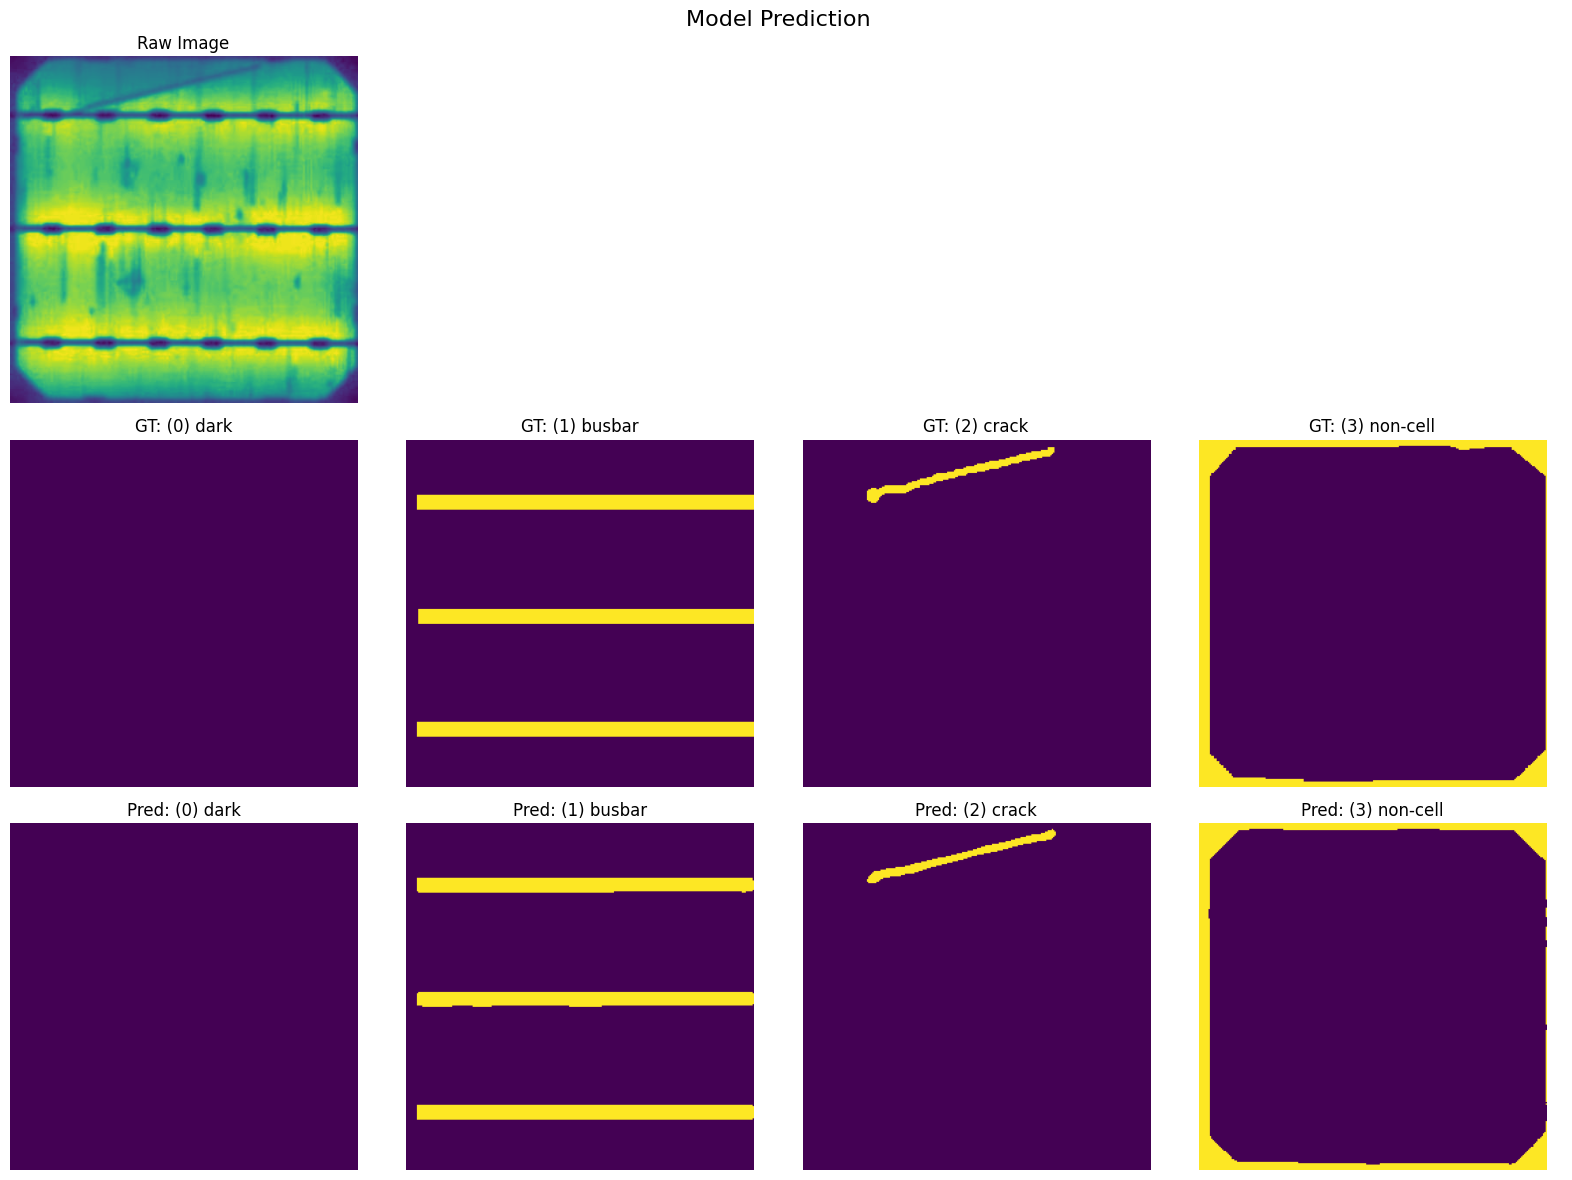

In [9]:
viz_functions.channeled_inference_and_show(
    train_loader, device, model, category_mapping, -32
)

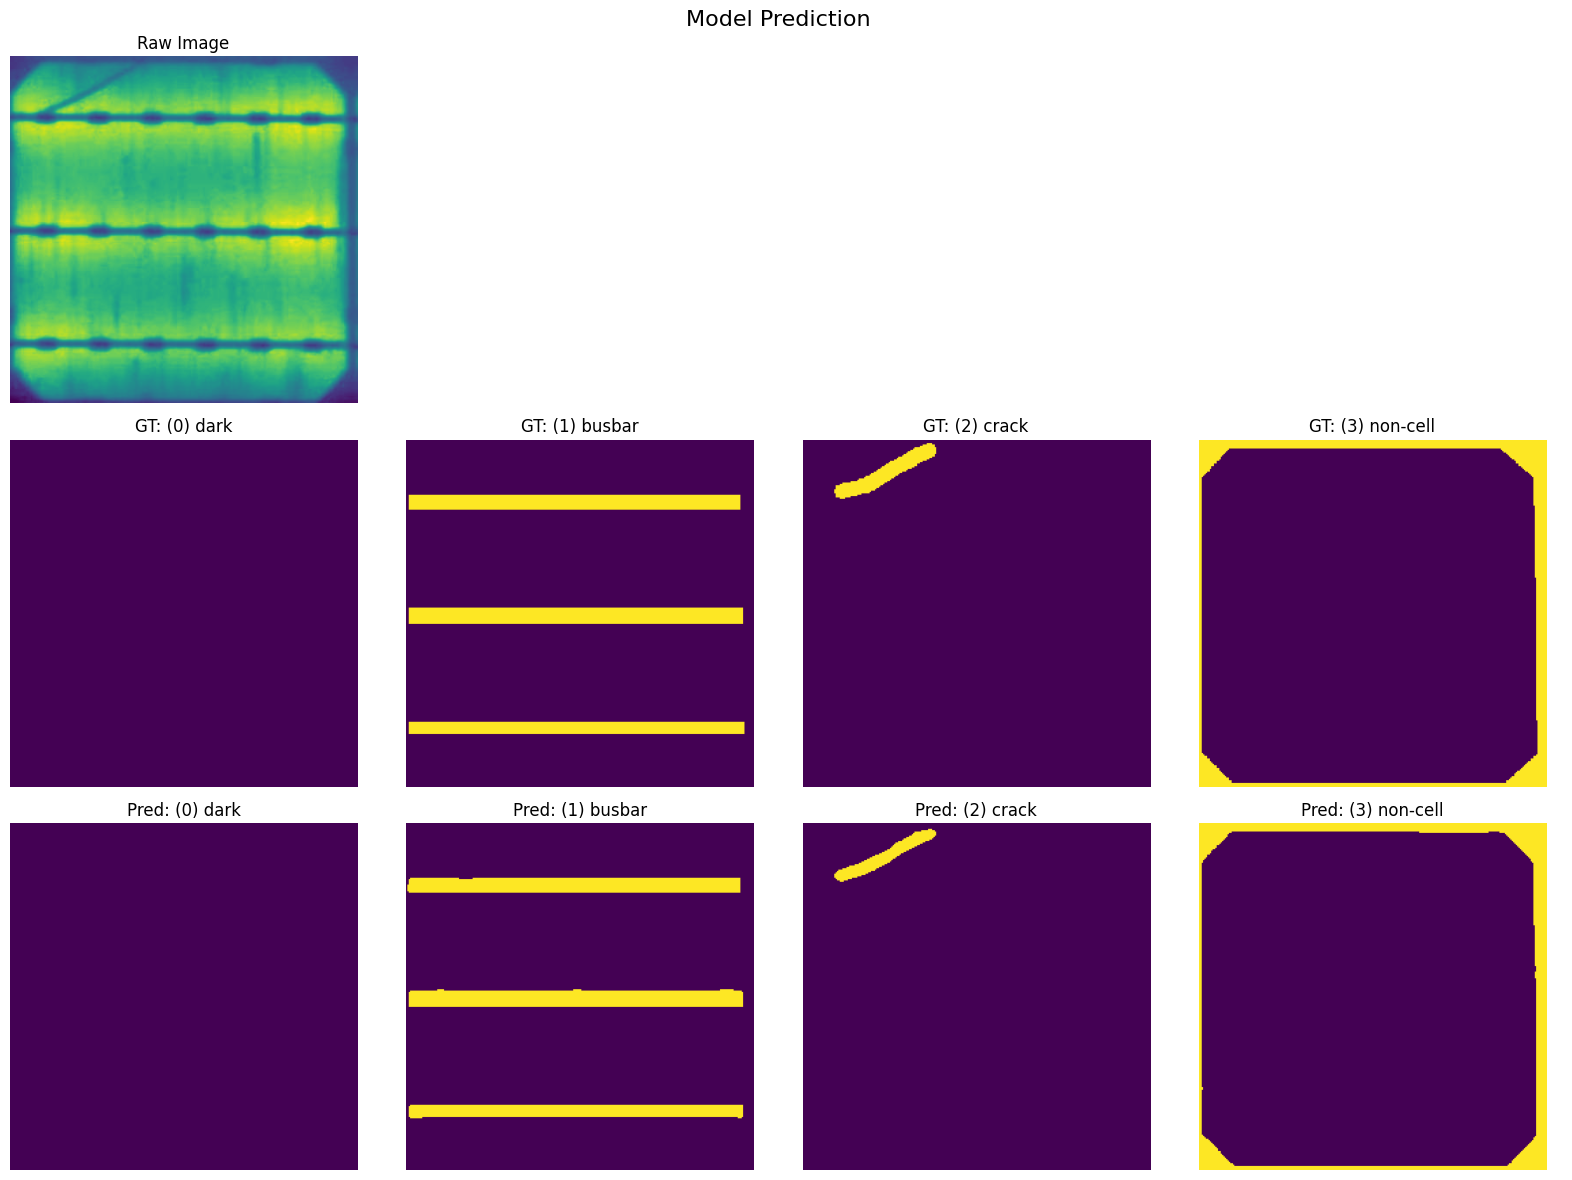

In [10]:
viz_functions.channeled_inference_and_show(
    train_loader, device, model, category_mapping, 13
)

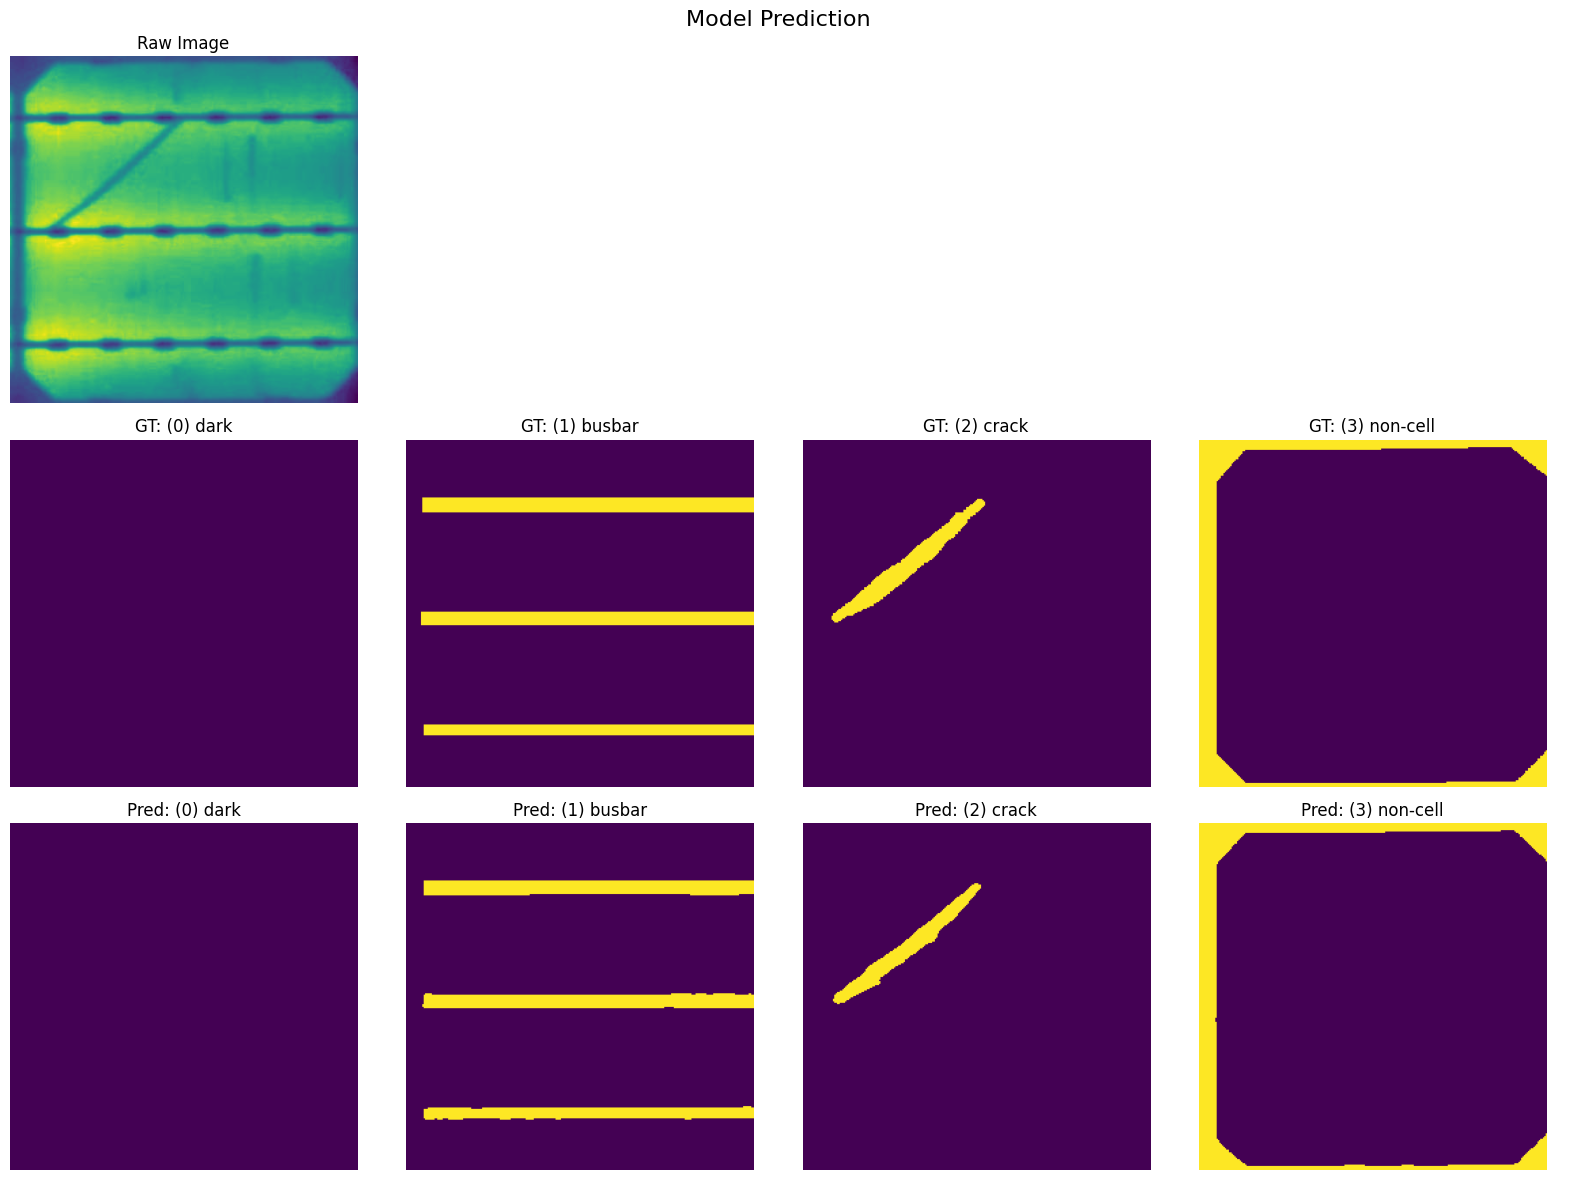

In [11]:
viz_functions.channeled_inference_and_show(
    train_loader, device, model, category_mapping, 44
)

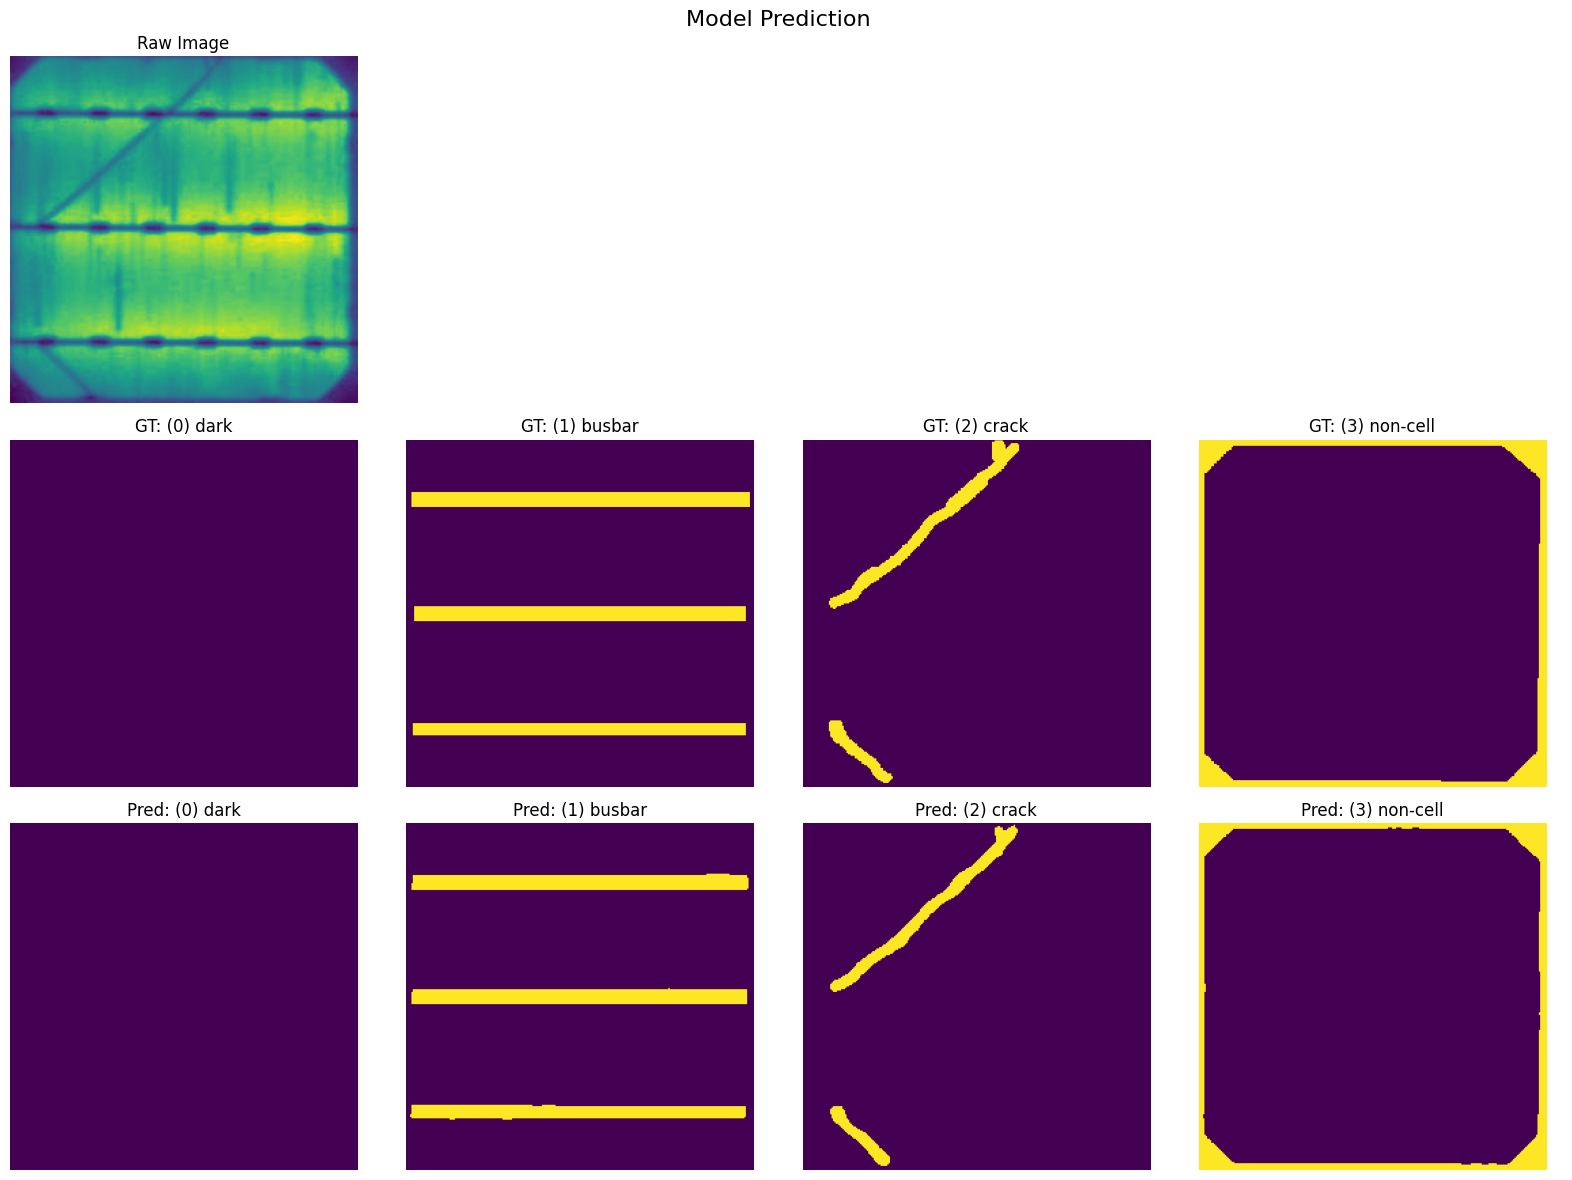

In [12]:
viz_functions.channeled_inference_and_show(
    train_loader, device, model, category_mapping, 1
)

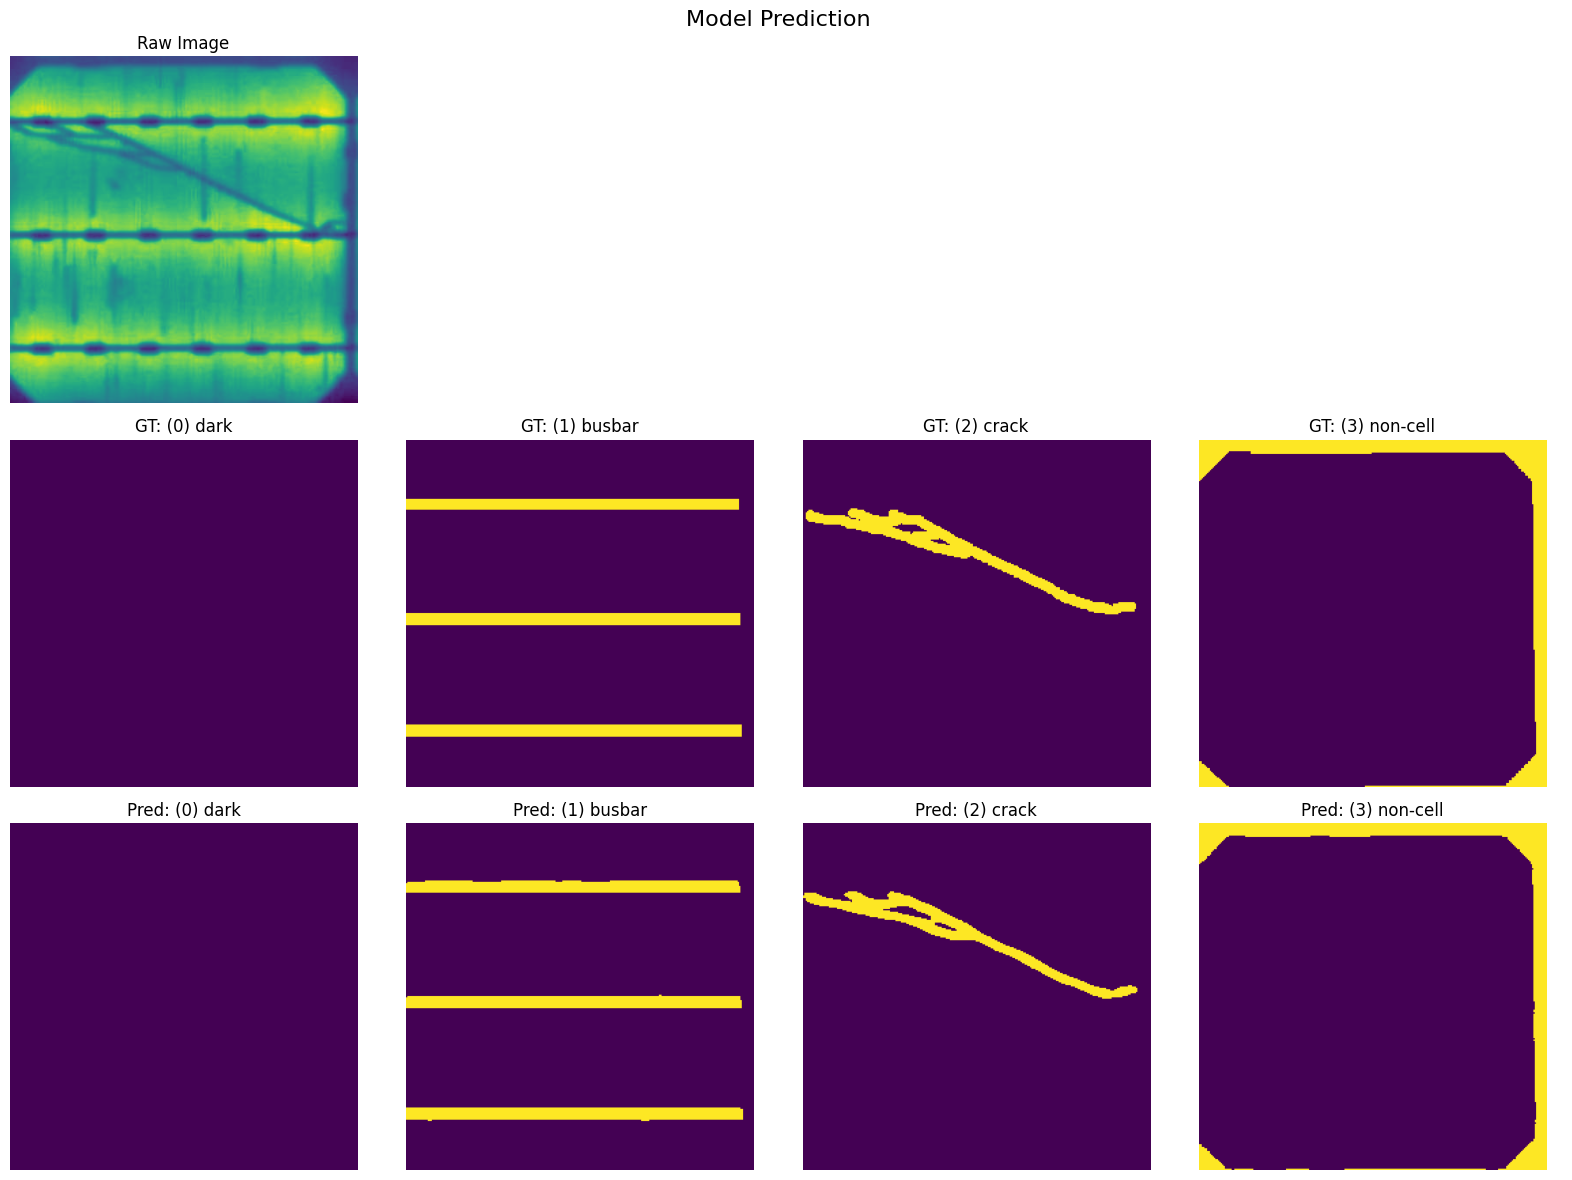

In [13]:
viz_functions.channeled_inference_and_show(
    train_loader, device, model, category_mapping, 6
)

In [14]:
# for i in range(100):
#     viz_functions.channeled_inference_and_show(train_loader, device, model, category_mapping, i)

[np.float64(0.17773719578304797), np.float64(0.04921260613223745), np.float64(0.03789128553576003), np.float64(0.03428059249880533), np.float64(0.03262211576762856), np.float64(0.031619937313843965), np.float64(0.03061801491705223), np.float64(0.030421598977857053), np.float64(0.028912451942590598), np.float64(0.02785533625119103), np.float64(0.02682034225993129), np.float64(0.02592017309457605), np.float64(0.024360479202676706), np.float64(0.023567645601345163), np.float64(0.022666449650488276), np.float64(0.021827848073200554), np.float64(0.020673953070112258), np.float64(0.019663127270302314), np.float64(0.018535935683757998), np.float64(0.017345321993418157), np.float64(0.016627587206262704), np.float64(0.01578940163489877), np.float64(0.01500432725070924), np.float64(0.014263412756342879), np.float64(0.013496571196328737), np.float64(0.012600903693560718), np.float64(0.012213048726393897), np.float64(0.01155252841154002), np.float64(0.010981197398415623), np.float64(0.010664452263

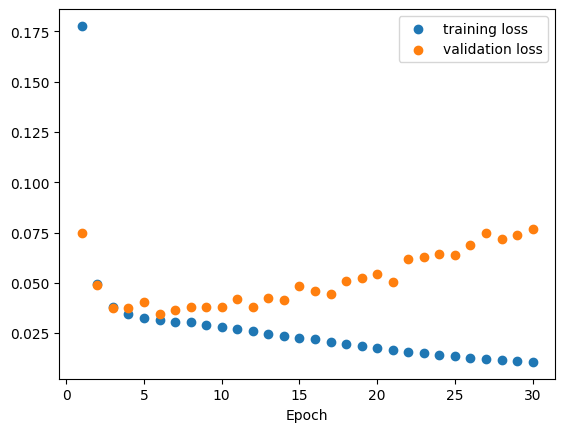

In [15]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [16]:
val_epoch_loss

[np.float64(0.0747760671358078),
 np.float64(0.04875569976866245),
 np.float64(0.03727746834882941),
 np.float64(0.037309030279851496),
 np.float64(0.040677900213159174),
 np.float64(0.03464673094562868),
 np.float64(0.036293555297849014),
 np.float64(0.03784779386204851),
 np.float64(0.03800585789359214),
 np.float64(0.03773785246989857),
 np.float64(0.04178606117995949),
 np.float64(0.038143011108518414),
 np.float64(0.04229559212660369),
 np.float64(0.0412283920798387),
 np.float64(0.048330034682543106),
 np.float64(0.04606344963376147),
 np.float64(0.04452345707716468),
 np.float64(0.05094518537561481),
 np.float64(0.05261154797596809),
 np.float64(0.05422328571733247),
 np.float64(0.050644107294292785),
 np.float64(0.06201701005721767),
 np.float64(0.06288471313702881),
 np.float64(0.06430225209611604),
 np.float64(0.06361423077412014),
 np.float64(0.06877409563893373),
 np.float64(0.07486379161301969),
 np.float64(0.07157800557553513),
 np.float64(0.07390412288662206),
 np.float6

In [17]:
save_dir

'/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise//checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise5'